In [2]:
import pandas as pd


In [3]:
df = pd.read_csv('../MSFT.csv')
df = df[['Date', 'Close']]
df


,Date,Close
0,1986-03-13,0.097222
1,1986-03-14,0.100694
2,1986-03-17,0.102431
3,1986-03-18,0.099826
4,1986-03-19,0.098090
...,...,...
9489,2023-11-06,356.529999
9490,2023-11-07,360.529999
9491,2023-11-08,363.200012
9492,2023-11-09,360.690002


In [4]:
from datetime import datetime

def convertStringtoDate(s):
    l = s.split('-')
    y, m, d = int(l[0]), int(l[1]), int(l[2])
    return datetime(year=y, month=m, day=d)


In [5]:
df['Date'] = df['Date'].apply(convertStringtoDate)
df.index = df.pop('Date')
df


,Close
Date,
1986-03-13,0.097222
1986-03-14,0.100694
1986-03-17,0.102431
1986-03-18,0.099826
1986-03-19,0.098090
...,...
2023-11-06,356.529999
2023-11-07,360.529999
2023-11-08,363.200012


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


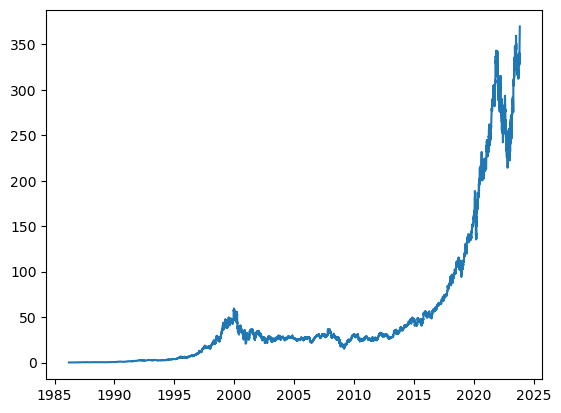

In [6]:
import matplotlib.pyplot as plt
plt.plot(df.index, df['Close'])


In [7]:
from datetime import timedelta
def getNextDateFromData(df, curr_date):
    ind = df.index.get_loc(curr_date)
    return df.index[ind+1]


In [8]:
import numpy as np

def createWindowedDataframe(df, start, end, w=1):
    start_date = convertStringtoDate(start)
    end_date = convertStringtoDate(end)
    curr_date = start_date
    reached_end = False

    dates = []
    features, target = [], []
    
    while not reached_end:
        df_window = df.loc[:curr_date].tail(w+1)

        if (len(df_window) != w+1):
            raise Exception(f'Window size too large for date {curr_date}')
        
        closing_values = df_window['Close'].to_numpy()
        X, y = closing_values[:-1], closing_values[-1]

        dates.append(curr_date)
        features.append(X)
        target.append(y)

        if curr_date == end_date:
            reached_end = True
        else:
            curr_date = getNextDateFromData(df, curr_date)

    windowed_dataframe = pd.DataFrame({})
    windowed_dataframe['Target Date'] = dates
    features = np.array(features)

    for i in range(w):
        windowed_dataframe[f'Target-{w-i}'] = features[:,i]
    
    windowed_dataframe['Target'] = target
    return windowed_dataframe

windowed_dataframe = createWindowedDataframe(df, '2021-08-20', '2023-10-05', w=3)
windowed_dataframe


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-08-20,293.079987,290.730011,296.769989,304.359985
1,2021-08-23,290.730011,296.769989,304.359985,304.649994
2,2021-08-24,296.769989,304.359985,304.649994,302.619995
3,2021-08-25,304.359985,304.649994,302.619995,302.010010
4,2021-08-26,304.649994,302.619995,302.010010,299.089996
...,...,...,...,...,...
530,2023-09-29,312.140015,312.790009,313.640015,315.750000
531,2023-10-02,312.790009,313.640015,315.750000,321.799988
532,2023-10-03,313.640015,315.750000,321.799988,313.390015
533,2023-10-04,315.750000,321.799988,313.390015,318.959991


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


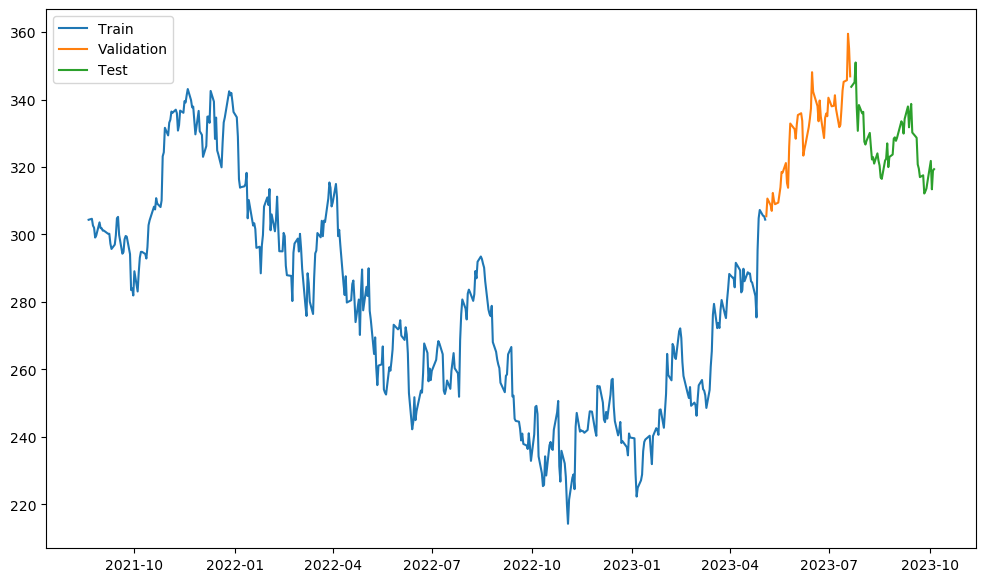

(428, 3, 1)


,Target Date,Target-3,Target-2,Target-1,Target
0,2021-08-20,293.079987,290.730011,296.769989,304.359985
1,2021-08-23,290.730011,296.769989,304.359985,304.649994
2,2021-08-24,296.769989,304.359985,304.649994,302.619995
3,2021-08-25,304.359985,304.649994,302.619995,302.010010
4,2021-08-26,304.649994,302.619995,302.010010,299.089996
...,...,...,...,...,...
530,2023-09-29,312.140015,312.790009,313.640015,315.750000
531,2023-10-02,312.790009,313.640015,315.750000,321.799988
532,2023-10-03,313.640015,315.750000,321.799988,313.390015
533,2023-10-04,315.750000,321.799988,313.390015,318.959991


In [9]:
def train_val_test_split(windowed_dataframe, train_ratio, test_ratio):
    df = windowed_dataframe[:]
    dates = df.pop('Target Date')
    df = df.to_numpy()
    features = df[:, :-1]
    features = features.reshape((len(df), features.shape[1], 1)).astype(np.float32)
    target = df[:, -1].astype(np.float32)

    train_split_point = int(len(df)*train_ratio)
    test_split_point = int(len(df)*(1-test_ratio))
    
    train_dates = dates[:train_split_point]
    train_X = features[:train_split_point]
    train_y = target[:train_split_point]

    val_dates = dates[train_split_point:test_split_point]
    val_X = features[train_split_point:test_split_point]
    val_y = target[train_split_point:test_split_point]

    test_dates = dates[test_split_point:]
    test_X = features[test_split_point:]
    test_y = target[test_split_point:]

    plt.figure(figsize=(12,7))
    plt.plot(train_dates, train_y)
    plt.plot(val_dates, val_y)
    plt.plot(test_dates, test_y)
    plt.legend(['Train', 'Validation', 'Test'])
    plt.show()

    return train_dates, train_X, train_y, val_dates, val_X, val_y, test_dates, test_X, test_y

train_dates, train_X, train_y, val_dates, val_X, val_y, test_dates, test_X, test_y = train_val_test_split(windowed_dataframe, 0.8, 0.1)
print(train_X.shape)
windowed_dataframe


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


2023-11-12 15:45:03.566780: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 15:45:03.614009: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-12 15:45:03.614985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 15:45:04.791596: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
model = Sequential([
    layers.Input((3,1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mean_absolute_error'])
model.fit(train_X, train_y, validation_data=(val_X, val_y), epochs=500)


Epoch 1/500
14/14 [==============================] - 2s 38ms/step - loss: 78376.3672 - mean_absolute_error: 278.2495 - val_loss: 108511.9141 - val_mean_absolute_error: 329.1570
Epoch 2/500
14/14 [==============================] - 0s 4ms/step - loss: 77722.9688 - mean_absolute_error: 277.0759 - val_loss: 107703.8672 - val_mean_absolute_error: 327.9270
Epoch 3/500
14/14 [==============================] - 0s 5ms/step - loss: 76986.7031 - mean_absolute_error: 275.7438 - val_loss: 106795.7188 - val_mean_absolute_error: 326.5396
Epoch 4/500
14/14 [==============================] - 0s 5ms/step - loss: 76014.6016 - mean_absolute_error: 273.9706 - val_loss: 105210.7344 - val_mean_absolute_error: 324.1035
Epoch 5/500
14/14 [==============================] - 0s 4ms/step - loss: 74634.9062 - mean_absolute_error: 271.4449 - val_loss: 103627.0312 - val_mean_absolute_error: 321.6509
Epoch 6/500
14/14 [==============================] - 0s 4ms/step - loss: 73066.3750 - mean_absolute_error: 268.5307 - v

14/14 [==============================] - 0s 1ms/step


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


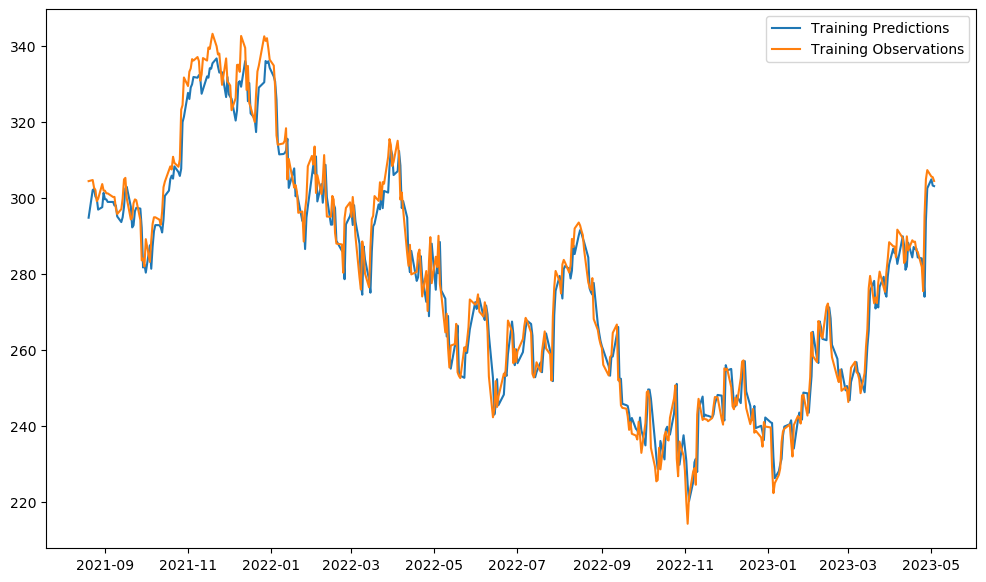

In [12]:
train_predictions = model.predict(train_X)
plt.figure(figsize=(12,7))
plt.plot(train_dates, train_predictions)
plt.plot(train_dates, train_y)
plt.legend(['Training Predictions', 'Training Observations'])
plt.show()


2/2 [==============================] - 0s 3ms/step


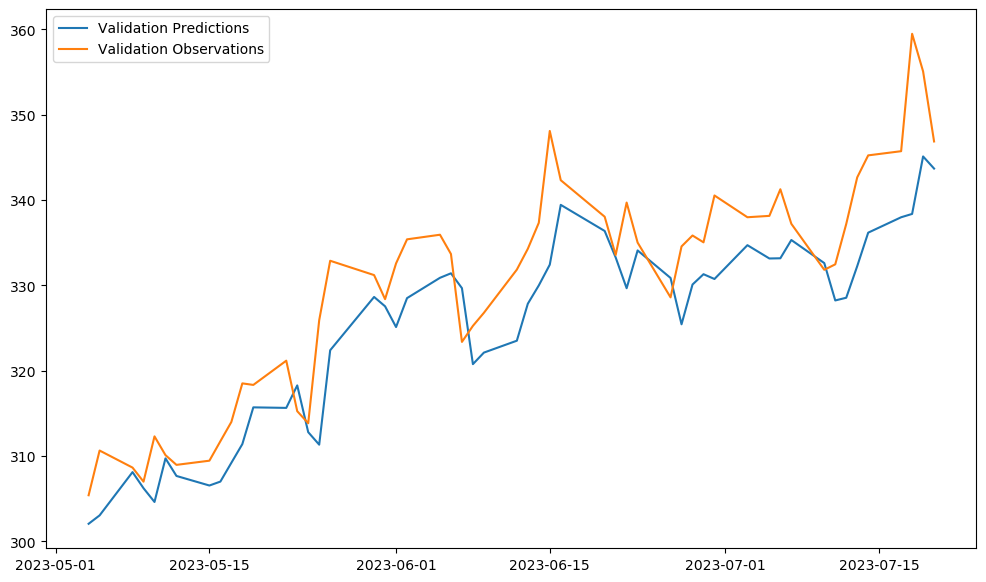

In [13]:
val_predictions = model.predict(val_X)
plt.figure(figsize=(12, 7))
plt.plot(val_dates, val_predictions)
plt.plot(val_dates, val_y)
plt.legend(['Validation Predictions', 'Validation Observations'])
plt.show()


2/2 [==============================] - 0s 2ms/step


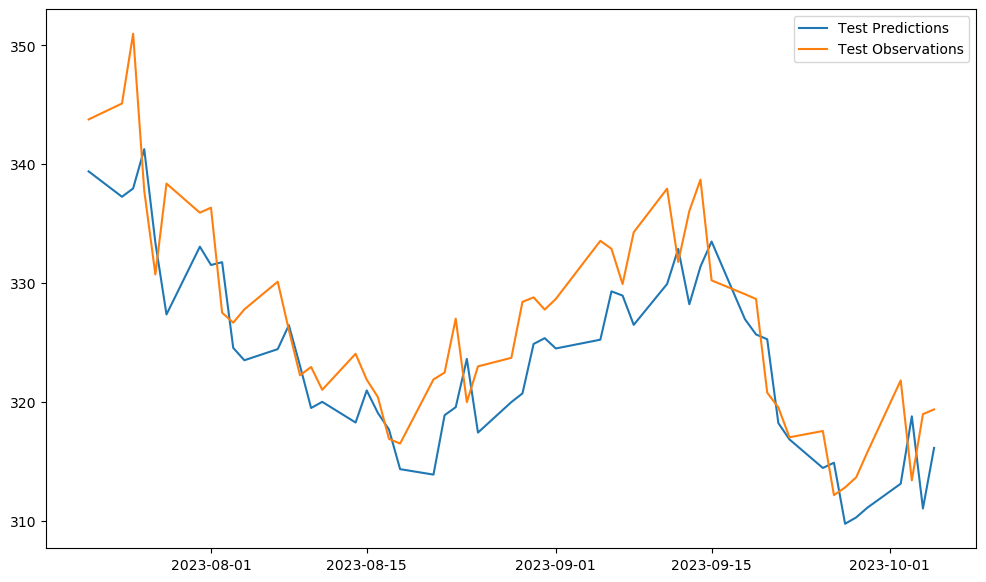

In [14]:
test_predictions = model.predict(test_X)
plt.figure(figsize=(12, 7))
plt.plot(test_dates, test_predictions)
plt.plot(test_dates, test_y)
plt.legend(['Test Predictions', 'Test Observations'])
plt.show()


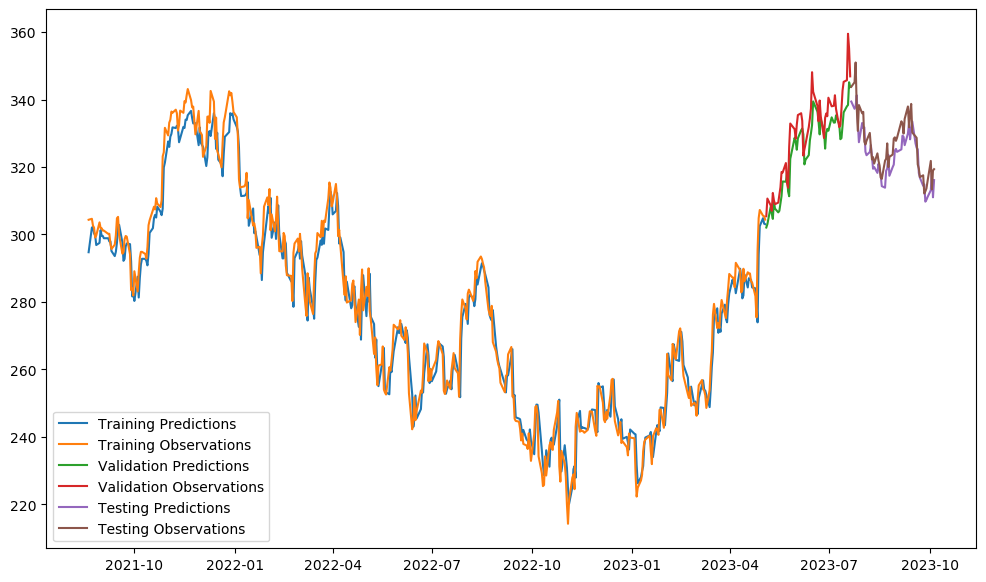

In [22]:
plt.figure(figsize=(12,7))
plt.plot(train_dates, train_predictions)
plt.plot(train_dates, train_y)
plt.plot(val_dates, val_predictions)
plt.plot(val_dates, val_y)
plt.plot(test_dates, test_predictions)
plt.plot(test_dates, test_y)

plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

plt.show()
